In [2]:
import argparse
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from prae.plots import plot_rn, plot_actions, plot_vertices
%matplotlib notebook

In [3]:
def visualize(agg_states, rewards, actions, colors=None):
    """
    """
    fig, ax = plot_rn()
    actioned_states = [agg_states]
    for a, v_a in enumerate(actions):
        new_states = agg_states + v_a
        actioned_states.append(new_states)

    all_vertices = np.concatenate(actioned_states, axis=0)

    pca = PCA(n_components=3)

    all_vertices = pca.fit_transform(all_vertices)

    n_v = agg_states.shape[0]
    vertices = all_vertices[:n_v]

    ax = plot_actions(ax, vertices, all_vertices, n_v, actions)
    
    if colors is None:
        colors = rewards


    ax, fig = plot_vertices(vertices, fig=fig, ax=ax, colors=colors)
    return ax, fig


In [4]:
from prae.runner import Runner
from prae.helpers import set_seeds, make_env
from argparse import Namespace

args = Namespace()

args.log_dir = "room_double"
args.data_folder = "room_double"

args.n_episodes = 1000
args.model_train_epochs = 100
args.n_neg_samples = 5
args.batch_size = 1024
args.batch_size_sample = 1024
args.lr = 0.001
args.hinge = 1.0
args.env = "room"
args.z_dim = 50
args.trans_tau = 0.01
args.prune_off = False

args.n_sweeps = 500
args.gamma = 0.9
args.objects = 2
args.test_goals = False
args.test_set = False
args.seed = 0
args.cpu = False

set_seeds(int(args.seed))                                                   
env = make_env(args) 

In [4]:
runner = Runner(env, args)                                                  
runner.loop() 

Sampling train trajectories 0 to 1000
Sampling valid trajectories 0 to 200
Number of samples=79911
Number of samples=17324
Train epoch 0
Training 2002905 params
progress |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% complete
 train loss 2.5468534729148766 17.405192852020264 s
valid loss 1.355856551843531████████████████████████████████████████████████████████████████████████████------| 94.1% complete
Train epoch 1
Training 2002905 params
progress |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% complete
 train loss 0.9844271744353862 18.30523705482483 s
valid loss 0.5479830012601965███████████████████████████████████████████████████████████████████████████------| 94.1% complete
Train epoch 2
Training 2002905 params
progress |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% complete
 train loss 0.50538243409

valid loss 0.29201486356118145██████████████████████████████████████████████████████████████████████████------| 94.1% complete
Train epoch 47
Training 2002905 params
progress |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% complete
 train loss 0.30904806527910356 17.834038734436035 s
valid loss 0.2910788409850177███████████████████████████████████████████████████████████████████████████------| 94.1% complete
Train epoch 48
Training 2002905 params
progress |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% complete
 train loss 0.30507378412198416 17.973479747772217 s
valid loss 0.2874947225346285███████████████████████████████████████████████████████████████████████████------| 94.1% complete
Train epoch 49
Training 2002905 params
progress |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% complete
 train loss 0.3

valid loss 0.28152453022844653██████████████████████████████████████████████████████████████████████████------| 94.1% complete
Train epoch 94
Training 2002905 params
progress |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% complete
 train loss 0.29622100199325174 17.74436593055725 s
valid loss 0.2813999933354995███████████████████████████████████████████████████████████████████████████------| 94.1% complete
Train epoch 95
Training 2002905 params
progress |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% complete
 train loss 0.2937905539440203 17.676108360290527 s
valid loss 0.2785620303714977███████████████████████████████████████████████████████████████████████████------| 94.1% complete
Train epoch 96
Training 2002905 params
progress |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% complete
 train loss 0.297

In [5]:
from prae.evaluator import plan
from prae.helpers import load_abstract_mdp, get_model, load_network

epoch = 99

network = get_model(env.action_space.n, args)
network = load_network(network, f"runs/{args.log_dir}/{args.seed}", epoch)

In [6]:
log_path = f"runs/{args.log_dir}/{args.seed}/{epoch}"
mdp = load_abstract_mdp(os.path.join("runs", args.log_dir, str(args.seed)), epoch, network, args.trans_tau, args.gamma)
s_str = "a_states.npy"
r_str = "a_rewards.npy"
a_str = "a_actions.npy"

/home/elise/Documents/public_aamas_code/plannable_action_equivariance/prae/helpers.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_latents = torch.tensor(latent_states).float().to(device)
/home/elise/Documents/public_aamas_code/plannable_action_equivariance/prae/helpers.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_latents = torch.tensor(latent_states).float().to(device)


In [7]:
from prae.evaluator import dump_epoch_mdp
env.reset()
goal_state = env.get_goal_state()
plans = plan(network, mdp, goal_state, env.action_space.n, args)
values = plans[0].detach().cpu()
qvalues = plans[1].detach().cpu()

dump_epoch_mdp(log_path, mdp, values, qvalues)

states = np.load(os.path.join(log_path, s_str),
                 allow_pickle=True)
rewards = np.load(os.path.join(log_path, r_str),
                 allow_pickle=True)[:, 0]
actions = np.load(os.path.join(log_path, a_str),
                  allow_pickle=True)

<IPython.core.display.Javascript object>


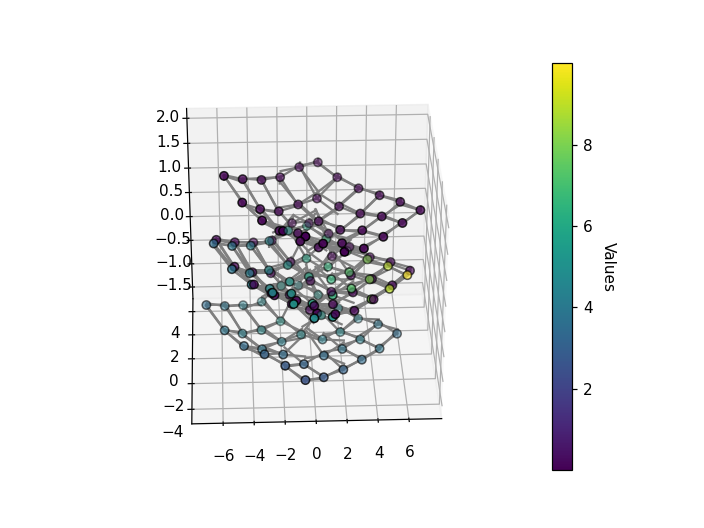

(<matplotlib.axes._subplots.Axes3DSubplot at 0x7f64dc303d30>,
 <Figure size 640x480 with 2 Axes>)

In [8]:
visualize(states, rewards, actions, colors=values)

In [9]:
from prae.evaluator import Evaluator
args.start_epochs = 0
args.model_train_epochs = 100
args.eval_eps = 100
args.eta = 1e-20
evaluator = Evaluator(env, args)                                            
returns, lens = evaluator.loop()

/home/elise/Documents/public_aamas_code/plannable_action_equivariance/prae/helpers.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_latents = torch.tensor(latent_states).float().to(device)
/home/elise/Documents/public_aamas_code/plannable_action_equivariance/prae/helpers.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_latents = torch.tensor(latent_states).float().to(device)


Epoch 0, return: -0.9162556943256243, length: 85.78
Epoch 1, return: -0.7931932167747123, length: 66.64
Epoch 2, return: -0.010816786891167624, length: 16.41
Epoch 3, return: 0.6481565256367654, length: 12.03
Epoch 4, return: 0.6894869375815115, length: 13.69
Epoch 5, return: 0.5888293141364034, length: 17.56
Epoch 6, return: 0.45135205081987223, length: 20.56
Epoch 7, return: 0.5250814023109245, length: 18.62
Epoch 8, return: 0.5753383342851577, length: 18.27
Epoch 9, return: 0.4422019831952832, length: 14.58
Epoch 10, return: 0.4971044225406611, length: 15.45
Epoch 11, return: 0.3252717373229955, length: 11.87
Epoch 12, return: 0.5886992636378844, length: 20.68
Epoch 13, return: 0.5327494819450602, length: 19.66
Epoch 14, return: 0.17040034604688814, length: 16.9
Epoch 15, return: 0.4433166473804465, length: 21.33
Epoch 16, return: 0.5494191003522423, length: 22.65
Epoch 17, return: 0.5438867399965749, length: 17.52
Epoch 18, return: 0.3372178114012533, length: 25.79
Epoch 19, return

<IPython.core.display.Javascript object>


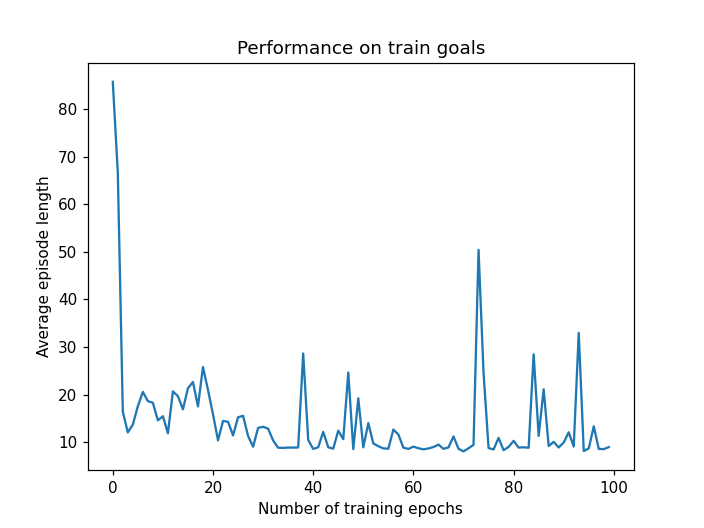

Text(0.5, 0, 'Number of training epochs')

In [10]:
fig, ax = plt.subplots(1)
ax.plot(lens, label="train")
ax.set_title("Performance on train goals")
ax.set_ylabel("Average episode length")
ax.set_xlabel("Number of training epochs")

In [11]:
args.test_goals = True
env = make_env(args)

In [12]:
evaluator = Evaluator(env, args)                                            
returns_test, lens_test = evaluator.loop()

Epoch 0, return: -0.942502381531252, length: 72.73
Epoch 1, return: -0.4249497333066231, length: 58.48
Epoch 2, return: 0.3886052947520672, length: 14.78
Epoch 3, return: 0.7608588455032431, length: 11.04
Epoch 4, return: 0.8401487131530831, length: 12.04
Epoch 5, return: 0.6775317297555158, length: 14.93
Epoch 6, return: 0.5138301088100288, length: 16.58
Epoch 7, return: 0.4371029933120183, length: 21.12
Epoch 8, return: 0.48758154047660457, length: 18.09
Epoch 9, return: 0.46040526390636366, length: 15.32
Epoch 10, return: 0.6947129255370232, length: 12.87
Epoch 11, return: 0.5087020948632643, length: 19.78
Epoch 12, return: 0.5432776616874647, length: 20.17
Epoch 13, return: 0.35378511130994866, length: 19.3
Epoch 14, return: 0.4315735786588432, length: 18.28
Epoch 15, return: 0.4613223717650156, length: 21.61
Epoch 16, return: 0.5882844054977887, length: 24.33
Epoch 17, return: 0.646449908124307, length: 12.63
Epoch 18, return: 0.4369921567700977, length: 17.35
Epoch 19, return: 0.

<IPython.core.display.Javascript object>


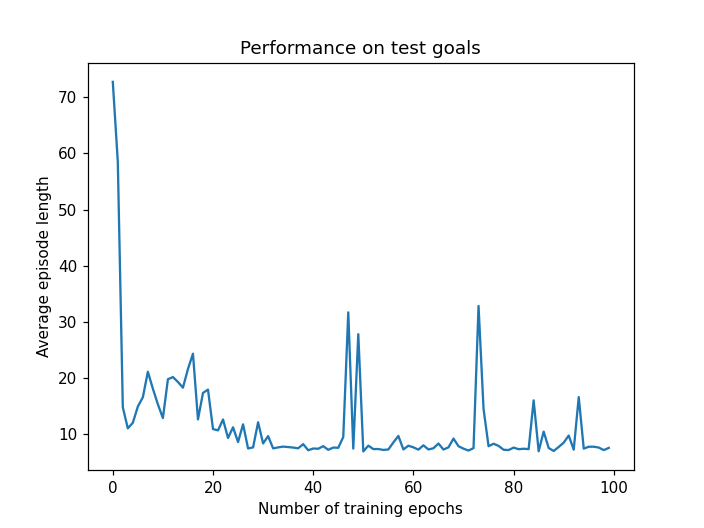

Text(0.5, 0, 'Number of training epochs')

In [13]:
fig, ax = plt.subplots(1)
ax.plot(lens_test, label="test")
ax.set_title("Performance on test goals")
ax.set_ylabel("Average episode length")
ax.set_xlabel("Number of training epochs")